<a href="https://colab.research.google.com/github/RidaKhan24/IIIT-AI-M--Course/blob/main/AIML_Module_1_Lab_3_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [5]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels

11490434/11490434 [==============================] - 0s 0us/step


Let us borrow a few functions from the previous labs:

In [6]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [7]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

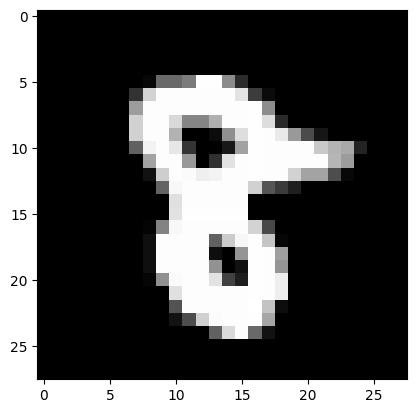

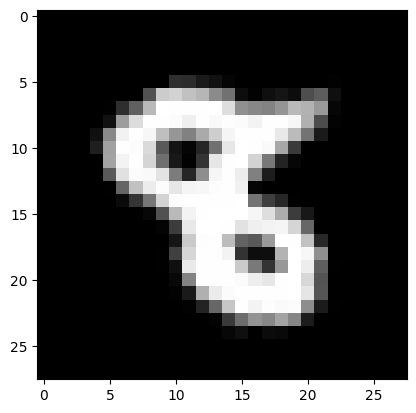

In [8]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [9]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

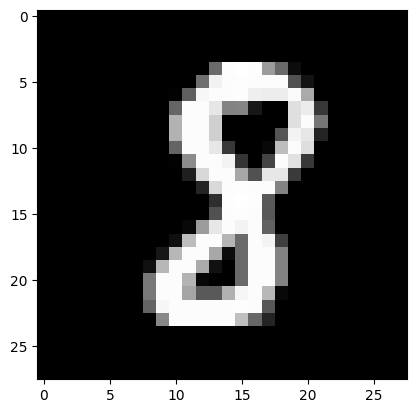

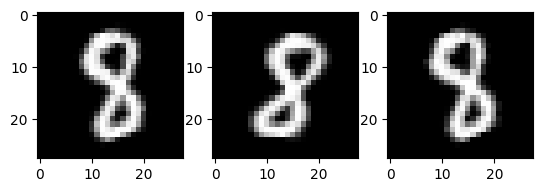

In [10]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [11]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6616


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [13]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-13-2f14d3721156>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here


Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6661
Accuracy after rotation augmentation constrained by  20  is  0.6601
Accuracy after rotation augmentation constrained by  30  is  0.681
Accuracy after rotation augmentation constrained by  40  is  0.6754
Accuracy after rotation augmentation constrained by  50  is  0.6749
Accuracy after rotation augmentation constrained by  60  is  0.6721
Accuracy after rotation augmentation constrained by  70  is  0.6623
Accuracy after rotation augmentation constrained by  80  is  0.6517
Accuracy after rotation augmentation constrained by  90  is  0.6491


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

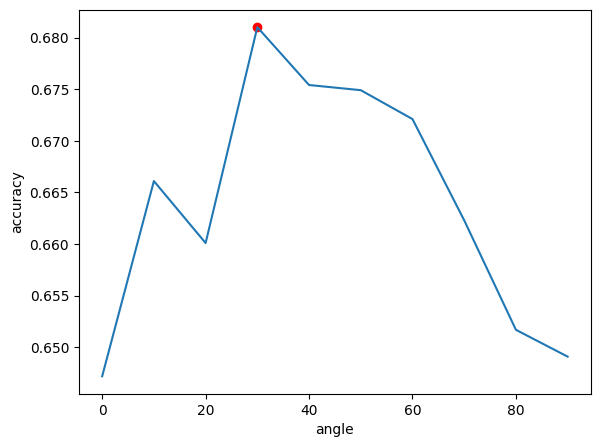

In [14]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [15]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

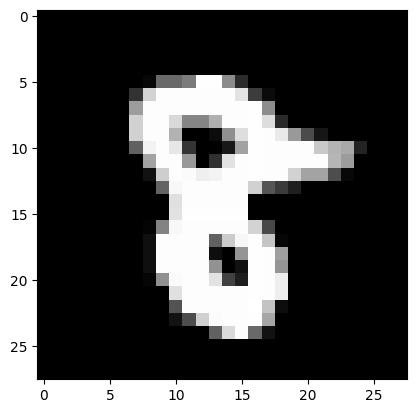

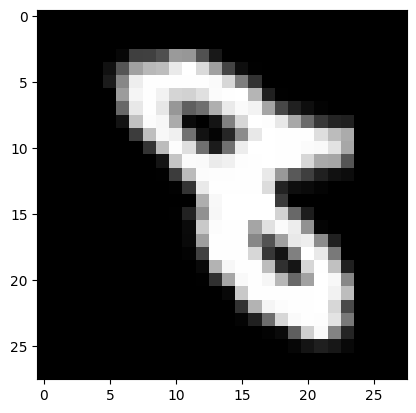

In [16]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [17]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [18]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-18-8a89fef4983d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here


Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6195
Accuracy after shear augmentation constrained by  0.4  is  0.6202
Accuracy after shear augmentation constrained by  0.6  is  0.6347
Accuracy after shear augmentation constrained by  0.8  is  0.6629
Accuracy after shear augmentation constrained by  1.0  is  0.6512
Accuracy after shear augmentation constrained by  1.2  is  0.6405
Accuracy after shear augmentation constrained by  1.4  is  0.6273
Accuracy after shear augmentation constrained by  1.6  is  0.6078
Accuracy after shear augmentation constrained by  1.8  is  0.6495
Accuracy after shear augmentation constrained by  2.0  is  0.6388


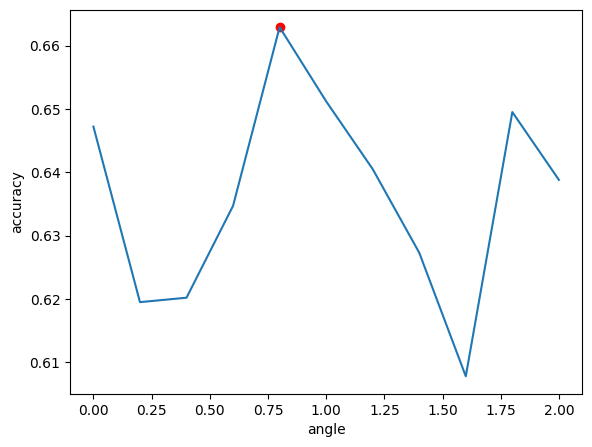

In [19]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [20]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [21]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

<ipython-input-21-09de780976d0>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here


Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.5941
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.6008
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.5943
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6002
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6021
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.616
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6339
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.6044
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.5954
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6013
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.5934
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.5854
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.6188
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6352
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.6

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

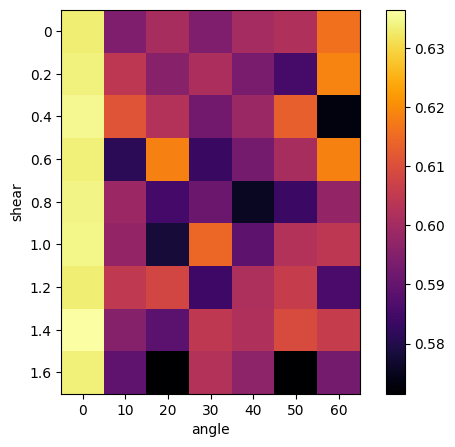

In [22]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

ANSWERS

1)  For angle = 0.0 and shear = 1.6 we got the best value of 0.635.The accuracy both combined is less than the accuracy without augmentation which is 0.6472.So shear and angle don't work well together.But we can see that for angle alone = 30 the accuracy is 0.6737 which is approximately 4% higher that of actual data without augmentation and for shear alone of 1.0 the accuracy is 0.6652 which is approximately 3% higher that of actual data without augmentation.

2)Yes,we can increase the accuracy by increasing the number of augmentation in case of little data as the more the data the merrier also the data will be diverse as in the case of images when we rotate we can see that the pixels change their positions and in shear we get data according to an axis so the data will be covered in all aspects. Since the data is being generated from existing data the noise is also avoided.

3) Some other augmentation techniques are shifting,adding noise to the image,blurring the images.



In [1]:
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian



In [23]:
sample = train_X[2]

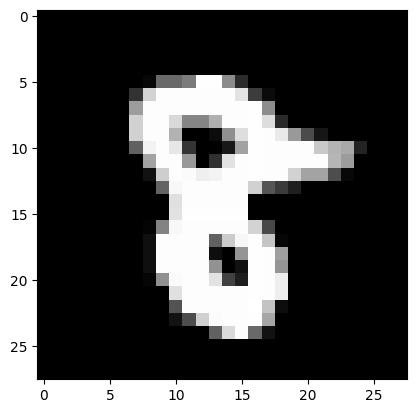

Text(0.5, 1.0, 'Wrap Shift')

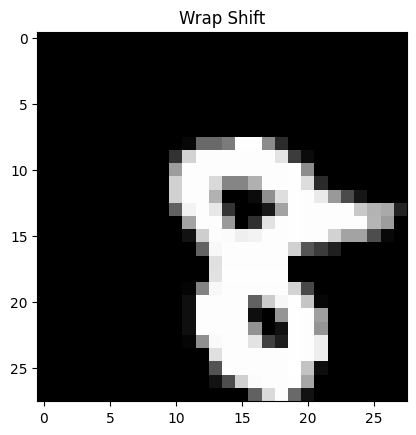

In [24]:
transform = AffineTransform(translation=(25,25))
plt.imshow(sample, cmap='gray')
plt.show()
wrapShift = warp(sample,transform,mode='wrap')
plt.imshow(wrapShift,cmap = 'gray')
plt.title('Wrap Shift')

In [25]:
def augShift(sample):
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = warp(sample[ii],transform,mode='wrap')
  return np.squeeze(nsample) # take care if the input had only one sample.

In [26]:
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for jj in range(naugmentations):
  augdata = np.concatenate((augdata, augShift(train_X))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
accuracy = Accuracy(test_y, testpred)
print('Accuracy after warp shift augmentation constrained is ', accuracy, flush=True)


Accuracy after warp shift augmentation constrained is  0.6271


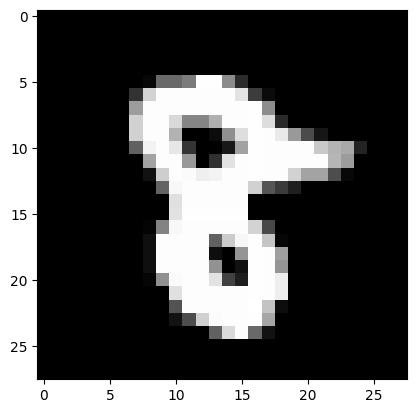

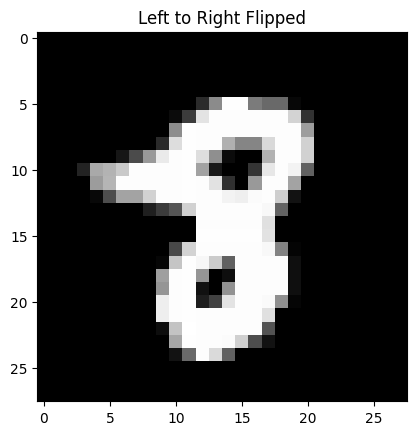

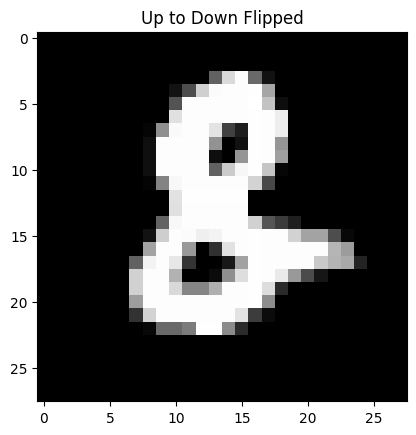

In [27]:
transform = AffineTransform(translation=(25,25))
plt.imshow(sample, cmap='gray')
plt.show()
flipLR = np.fliplr(sample)
plt.imshow(flipLR,cmap = 'gray')
plt.title('Left to Right Flipped')
plt.show()
flipUD = np.flipud(sample)
plt.imshow(flipUD,cmap = 'gray')
plt.title('Up to Down Flipped')
plt.show()

In [28]:
def augLR(sample):
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = np.fliplr(sample[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

In [29]:
def augUD(sample):
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = np.flipud(sample[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

In [30]:
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for jj in range(naugmentations):
  augdata = np.concatenate((augdata, augLR(train_X))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
accuracy = Accuracy(test_y, testpred)
print('Accuracy after left to Right augmentation constrained is ', accuracy, flush=True)

augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for jj in range(naugmentations):
  augdata = np.concatenate((augdata, augUD(train_X))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
accuracy = Accuracy(test_y, testpred)
print('Accuracy after up to down flip augmentation constrained is ', accuracy, flush=True)


Accuracy after left to Right augmentation constrained is  0.6238
Accuracy after up to down flip augmentation constrained is  0.6175


Accuracy after left to Right augmentation constrained is  0.6238

Accuracy after up to down flip augmentation constrained is  0.6175

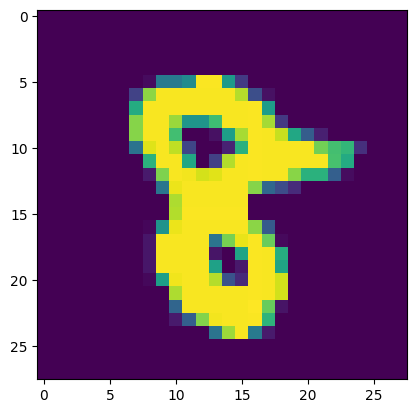

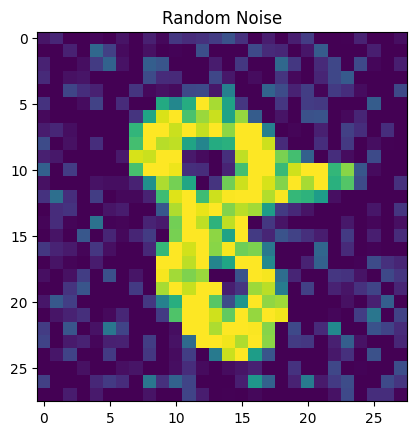

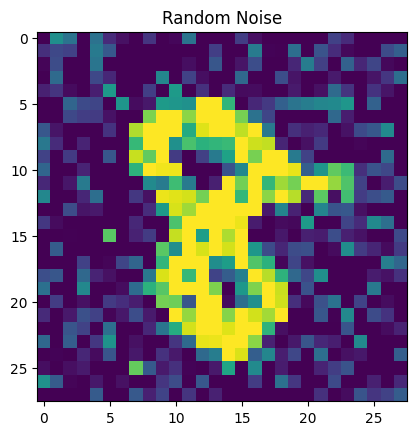

In [31]:
transform = AffineTransform(translation=(25,25))
plt.imshow(sample)
plt.show()
#standard deviation for noise to be added in the image
sigma=0.155
#add random noise to the image
noisyRandom = random_noise(sample,var=sigma**2)

plt.imshow(noisyRandom)
plt.title('Random Noise')
plt.show()

sigma=0.255
#add random noise to the image
noisyRandom = random_noise(sample,var=sigma**2)

plt.imshow(noisyRandom)
plt.title('Random Noise')
plt.show()

In [32]:
def augNoise(sample,sigma):
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = random_noise(sample[ii],var=sigma**2)
  return np.squeeze(nsample) # take care if the input had only one sample.

In [33]:
sigmas = [0.1,0.155,0.175,0.2,0.225,0.275,0.3,0.325,0.35,0.375]
accuracies = np.zeros(len(sigmas), dtype=np.float)

for i in range(len(sigmas)):
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augNoise(train_X,sigmas[i]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[i] = Accuracy(test_y, testpred)
  print('Accuracy after adding noise by sigma of ',sigmas[i],' augmentation constrained is ', accuracies[i], flush=True)

<ipython-input-33-bff330c04f7f>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(sigmas), dtype=np.float)


Accuracy after adding noise by sigma of  0.1  augmentation constrained is  0.64
Accuracy after adding noise by sigma of  0.155  augmentation constrained is  0.6443
Accuracy after adding noise by sigma of  0.175  augmentation constrained is  0.6439
Accuracy after adding noise by sigma of  0.2  augmentation constrained is  0.6475
Accuracy after adding noise by sigma of  0.225  augmentation constrained is  0.6458
Accuracy after adding noise by sigma of  0.275  augmentation constrained is  0.6475
Accuracy after adding noise by sigma of  0.3  augmentation constrained is  0.6472
Accuracy after adding noise by sigma of  0.325  augmentation constrained is  0.6472
Accuracy after adding noise by sigma of  0.35  augmentation constrained is  0.6472
Accuracy after adding noise by sigma of  0.375  augmentation constrained is  0.6472


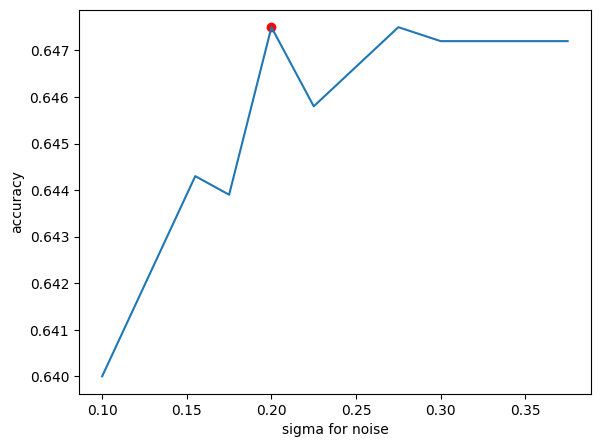

In [34]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(sigmas, accuracies)
ax.set_xlabel('sigma for noise')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(sigmas[maxind], accuracies[maxind], c='red')

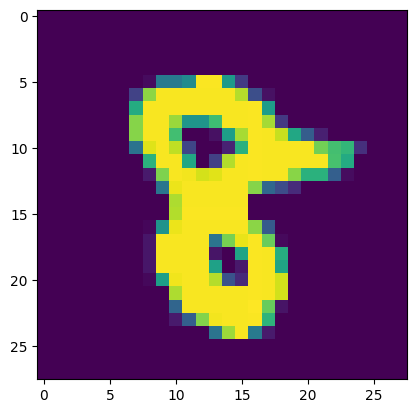

<ipython-input-35-12b83f87833a>:4: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  blurred = gaussian(sample,sigma=1,multichannel=True)


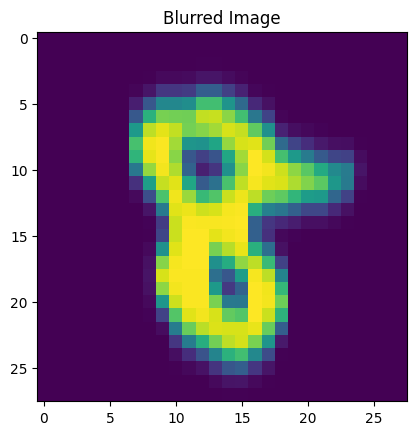

<ipython-input-35-12b83f87833a>:9: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  blurred = gaussian(sample,sigma=1.5,multichannel=True)


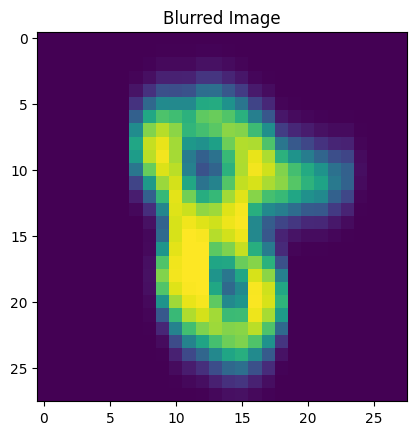

In [35]:
transform = AffineTransform(translation=(25,25))
plt.imshow(sample)
plt.show()
blurred = gaussian(sample,sigma=1,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')
plt.show()
blurred = gaussian(sample,sigma=1.5,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')
plt.show()

In [36]:
def augBlur(sample,sigma):
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = gaussian(sample[ii],sigma,multichannel=True)
  return np.squeeze(nsample) # take care if the input had only one sample.

In [37]:
sigmas = [1,1.55,1.75,2,2.25,2.75,3,3.25,3.5,3.75]
accuracies = np.zeros(len(sigmas), dtype=np.float)

for i in range(len(sigmas)):
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augBlur(train_X,sigmas[i]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[i] = Accuracy(test_y, testpred)
  print('Accuracy after adding blur by sigma of ',sigmas[i],' augmentation constrained is ', accuracies[i], flush=True)

<ipython-input-37-1cfbea6054eb>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(sigmas), dtype=np.float)
<ipython-input-36-06505365562d>:4: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  nsample[ii] = gaussian(sample[ii],sigma,multichannel=True)


Accuracy after adding blur by sigma of  1  augmentation constrained is  0.6776
Accuracy after adding blur by sigma of  1.55  augmentation constrained is  0.6826
Accuracy after adding blur by sigma of  1.75  augmentation constrained is  0.6821
Accuracy after adding blur by sigma of  2  augmentation constrained is  0.6805
Accuracy after adding blur by sigma of  2.25  augmentation constrained is  0.6746
Accuracy after adding blur by sigma of  2.75  augmentation constrained is  0.666
Accuracy after adding blur by sigma of  3  augmentation constrained is  0.6567
Accuracy after adding blur by sigma of  3.25  augmentation constrained is  0.6506
Accuracy after adding blur by sigma of  3.5  augmentation constrained is  0.6421
Accuracy after adding blur by sigma of  3.75  augmentation constrained is  0.6333


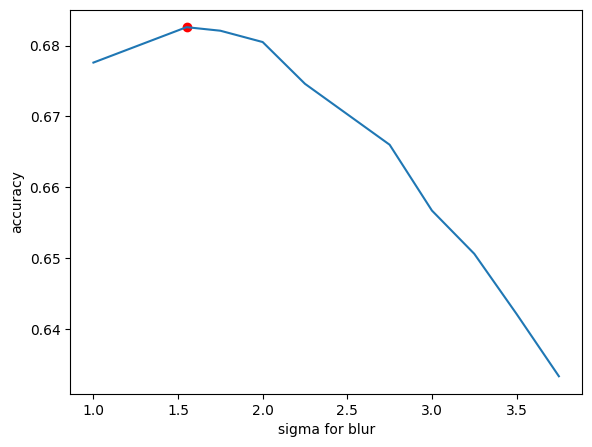

In [38]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(sigmas, accuracies)
ax.set_xlabel('sigma for blur')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(sigmas[maxind], accuracies[maxind], c='red')

4) Here we will try combination of blur and noise


In [39]:
def augBlurNoise(sample,sigma_blur,sigma_noise):
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = gaussian(random_noise(sample[ii],var=sigma_noise**2),sigma_blur,multichannel=True)
  return np.squeeze(nsample) # take care if the input had only one sample.

In [40]:
sigmas_noise = [0.1,0.155,0.175,0.2,0.225,0.275,0.3,0.325,0.35,0.375]
sigmas_blur = [1,1.55,1.75,2,2.25,2.75,3,3.25,3.5,3.75]
hyp = cartesian((sigmas_blur, sigmas_noise)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augBlurNoise(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation blur:',hyp[ii][0], 'noise:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

<ipython-input-40-3e8b124011a7>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here
<ipython-input-39-56755b8b193b>:4: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  nsample[ii] = gaussian(random_noise(sample[ii],var=sigma_noise**2),sigma_blur,multichannel=True)


Accuracy after augmentation blur: 1.0 noise: 0.1  is  0.6693
Accuracy after augmentation blur: 1.0 noise: 0.155  is  0.6714
Accuracy after augmentation blur: 1.0 noise: 0.175  is  0.6693
Accuracy after augmentation blur: 1.0 noise: 0.2  is  0.6662
Accuracy after augmentation blur: 1.0 noise: 0.225  is  0.6578
Accuracy after augmentation blur: 1.0 noise: 0.275  is  0.6645
Accuracy after augmentation blur: 1.0 noise: 0.3  is  0.6519
Accuracy after augmentation blur: 1.0 noise: 0.325  is  0.6486
Accuracy after augmentation blur: 1.0 noise: 0.35  is  0.6535
Accuracy after augmentation blur: 1.0 noise: 0.375  is  0.6463
Accuracy after augmentation blur: 1.55 noise: 0.1  is  0.6762
Accuracy after augmentation blur: 1.55 noise: 0.155  is  0.678
Accuracy after augmentation blur: 1.55 noise: 0.175  is  0.6702
Accuracy after augmentation blur: 1.55 noise: 0.2  is  0.6663
Accuracy after augmentation blur: 1.55 noise: 0.225  is  0.6723
Accuracy after augmentation blur: 1.55 noise: 0.275  is  0.665

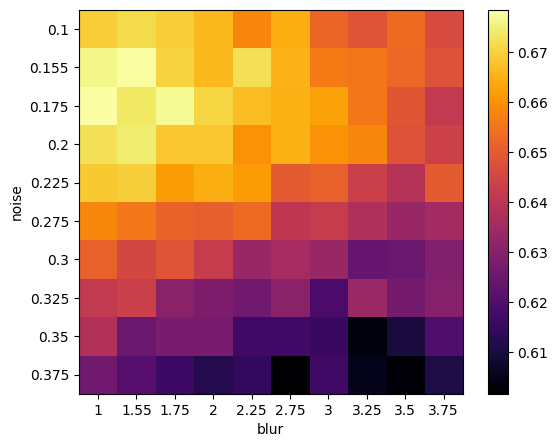

In [41]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(sigmas_blur), len(sigmas_noise))), cmap='inferno')
ax.set_xlabel('blur')
ax.set_ylabel('noise')
ax.set_xticks(np.arange(len(sigmas_blur)));
ax.set_xticklabels(sigmas_blur);
ax.set_yticks(np.arange(len(sigmas_noise)));
ax.set_yticklabels(sigmas_noise);
plt.colorbar(im)

In [42]:
def augNoiseShift(sample,sigma):
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] =  warp(random_noise(sample[ii],var=sigma**2),transform,mode='wrap')
  return np.squeeze(nsample) # take care if the input had only one sample.

In [43]:
sigmas = [0.1,0.155,0.175,0.2,0.225,0.275,0.3,0.325,0.35,0.375]
accuracies = np.zeros(len(sigmas), dtype=np.float)

for i in range(len(sigmas)):
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augNoiseShift(train_X,sigmas[i]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[i] = Accuracy(test_y, testpred)
  print('Accuracy after warp shift and adding noise by sigma of ',sigmas[i],' augmentation constrained is ', accuracies[i], flush=True)

<ipython-input-43-1813efe50760>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(sigmas), dtype=np.float)


Accuracy after warp shift and adding noise by sigma of  0.1  augmentation constrained is  0.6201
Accuracy after warp shift and adding noise by sigma of  0.155  augmentation constrained is  0.6258
Accuracy after warp shift and adding noise by sigma of  0.175  augmentation constrained is  0.6301
Accuracy after warp shift and adding noise by sigma of  0.2  augmentation constrained is  0.6333
Accuracy after warp shift and adding noise by sigma of  0.225  augmentation constrained is  0.6381
Accuracy after warp shift and adding noise by sigma of  0.275  augmentation constrained is  0.6439
Accuracy after warp shift and adding noise by sigma of  0.3  augmentation constrained is  0.6456
Accuracy after warp shift and adding noise by sigma of  0.325  augmentation constrained is  0.6465
Accuracy after warp shift and adding noise by sigma of  0.35  augmentation constrained is  0.6467
Accuracy after warp shift and adding noise by sigma of  0.375  augmentation constrained is  0.6472


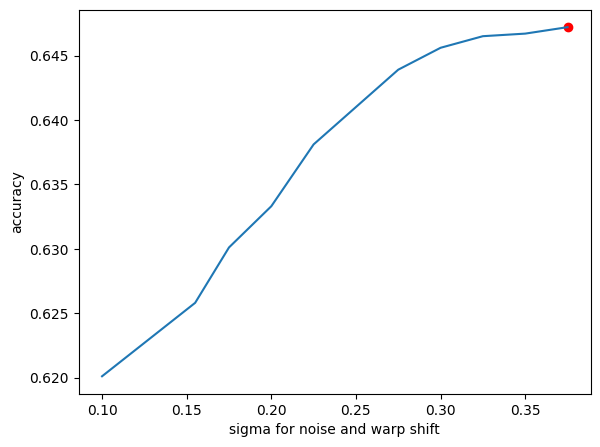

In [44]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(sigmas, accuracies)
ax.set_xlabel('sigma for noise and warp shift')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(sigmas[maxind], accuracies[maxind], c='red')

In [45]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::3100,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::3100].copy() # do the same to the labels

In [46]:
len(train_X)

20

In [47]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.4508


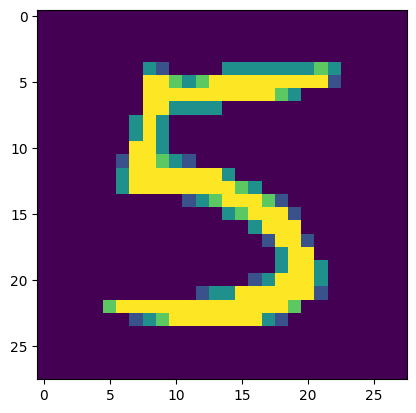

<ipython-input-48-e92f92110ce1>:5: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  blurred = gaussian(sample,sigma=1,multichannel=True)


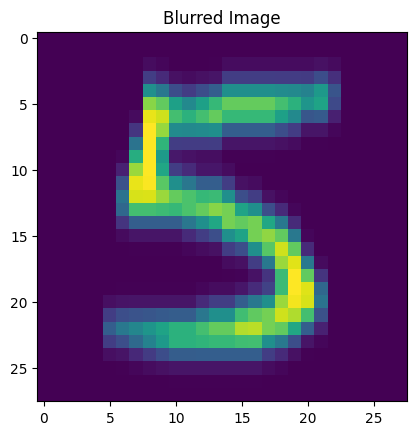

<ipython-input-48-e92f92110ce1>:10: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  blurred = gaussian(sample,sigma=1.5,multichannel=True)


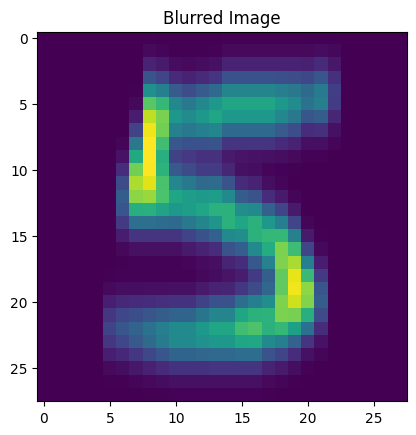

In [48]:
sample = train_X[2]
transform = AffineTransform(translation=(25,25))
plt.imshow(sample)
plt.show()
blurred = gaussian(sample,sigma=1,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')
plt.show()
blurred = gaussian(sample,sigma=1.5,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')
plt.show()

In [49]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

In [50]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.5,3.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-50-ddb03070823c>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here


Accuracy after shear augmentation constrained by  0  is  0.4508
Accuracy after shear augmentation constrained by  0.2  is  0.4543
Accuracy after shear augmentation constrained by  0.4  is  0.4749
Accuracy after shear augmentation constrained by  0.6  is  0.5035
Accuracy after shear augmentation constrained by  0.8  is  0.507
Accuracy after shear augmentation constrained by  1.0  is  0.493
Accuracy after shear augmentation constrained by  1.2  is  0.5081
Accuracy after shear augmentation constrained by  1.4  is  0.5177
Accuracy after shear augmentation constrained by  1.6  is  0.488
Accuracy after shear augmentation constrained by  1.8  is  0.4787
Accuracy after shear augmentation constrained by  2.0  is  0.4433
Accuracy after shear augmentation constrained by  2.5  is  0.426
Accuracy after shear augmentation constrained by  3.0  is  0.4185


In [51]:
#Thus for the least sample of 19 images without augmentation of accuracy 0.4508 by applying shear we got an accuracy of 0.5099 as the highest at sigma of 1.2